In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import glob as gb
import random
import seaborn as sns
import sklearn.metrics as metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [4]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import os, shutil, pathlib
!rm -rf /content/logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [7]:

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

In [8]:
train_dir = "C:\\Users\\Rafik\\Desktop\\Master Miv\\S2\\RNAA\\Projet\\train" 
val_dir = "C:\\Users\\Rafik\\Desktop\\Master Miv\\S2\\RNAA\\Projet\\valid"
test_dir = "C:\\Users\\Rafik\\Desktop\\Master Miv\\S2\\RNAA\\Projet\\test"

# Managing the extension of the files
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:

# Define parameters for the loader
batch_size = 32
img_height = 180
img_width = 180
image_shape = (180, 180)

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical', # enables one-hot encoded labels
    seed=123,
    shuffle = True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 436 files belonging to 8 classes.


In [11]:

# Load validation data
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical', # enables one-hot encoded labels
    seed=123,
    shuffle = False,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 108 files belonging to 8 classes.


In [13]:
# Load test data
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical', # enables one-hot encoded labels
    seed=123,
    shuffle = False,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 97 files belonging to 8 classes.


In [14]:

# Print class names
class_names = train_ds.class_names
display(class_names)

['Apple',
 'Beet',
 'Egg Plant',
 'Pepper',
 'Potato',
 'Squach',
 'Tomato',
 'carrot']

In [15]:
for folder in os.listdir(train_dir):
    files = gb.glob(pathname = str(train_dir +'//' + folder + '/*.jpg'))
    print(f'[Training] Found {len(files)} images for {folder}')

[Training] Found 61 images for Apple
[Training] Found 33 images for Beet
[Training] Found 34 images for carrot
[Training] Found 29 images for Egg Plant
[Training] Found 43 images for Pepper
[Training] Found 76 images for Potato
[Training] Found 0 images for Squach
[Training] Found 96 images for Tomato


In [16]:

for folder in  os.listdir(test_dir):
    files = gb.glob(pathname = str(test_dir +'//' + folder + '/*.jpg'))
    print(f'[Testing] Found {len(files)} images for {folder}')

[Testing] Found 20 images for Apple
[Testing] Found 8 images for Beet
[Testing] Found 10 images for carrot
[Testing] Found 7 images for Egg Plant
[Testing] Found 13 images for Peeper
[Testing] Found 18 images for Potato
[Testing] Found 0 images for Squash
[Testing] Found 6 images for Tomato


In [17]:
# Shapes of training image and label ds
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 8)


In [18]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
normalization_layer = layers.Rescaling(1.0/255)


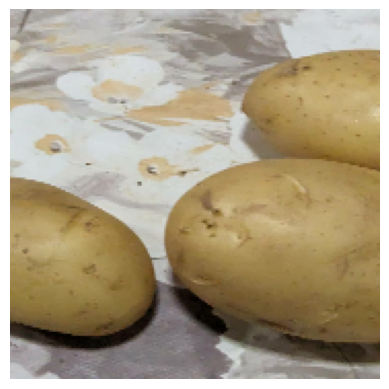

In [20]:

# Before standardizing
images, _ = next(iter(train_ds))
ex_img = images[0]

img = plt.imshow(ex_img.numpy().astype("uint8"))
plt.axis('off')
plt.show(img)


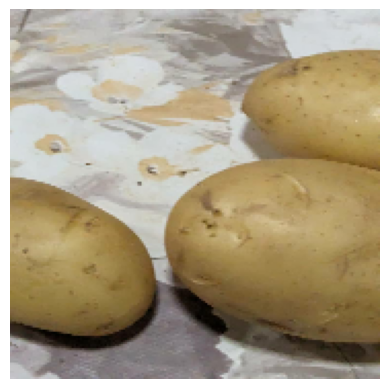

0.0 0.8927052


In [21]:
# after standardizing - looks good!
normalized_img = normalization_layer(ex_img)
normalized_img
img = plt.imshow(normalized_img)
plt.axis('off')
plt.show(img)
# Notice the pixel values are now between [0,1]
print(np.min(normalized_img), np.max(normalized_img))

In [22]:

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8927052


In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#just simple function bach augmontiw data

In [58]:
# model = Sequential([
#     layers.Input(shape=(img_height, img_width, 3)),
#     normalization_layer,   #layer bach nomralizw chwiya data
#     data_augmentation,
#     layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
#     layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#     layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
#     layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
#     layers.Flatten(),

#     layers.Dense(128, activation='relu'),
#     layers.Dense(10, activation='softmax')
# ])

model = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    keras.layers.Conv2D(filters=32,  kernel_size=3, activation='relu'),
    keras.layers.Conv2D(filters=32,  kernel_size=3, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=64,  kernel_size=3, activation='relu'),
    keras.layers.Conv2D(filters=64,  kernel_size=3, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=128,  kernel_size=3, activation='relu'),
    keras.layers.Conv2D(filters=128,  kernel_size=3, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(8, activation='sigmoid') 
])



In [59]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 88, 88, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 84, 84, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 42, 42, 64)        0         
 g2D)                                                 

In [60]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [62]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [early_stopping_callback]
)

Epoch 1/15


14/14 [==============================] - 74s 5s/step - loss: 17.8558 - accuracy: 0.1858 - val_loss: 2.3826 - val_accuracy: 0.1944
Epoch 2/15
14/14 [==============================] - 75s 5s/step - loss: 1.4675 - accuracy: 0.5252 - val_loss: 1.3704 - val_accuracy: 0.3796
Epoch 3/15
14/14 [==============================] - 75s 5s/step - loss: 0.8507 - accuracy: 0.7385 - val_loss: 1.0658 - val_accuracy: 0.6574
Epoch 4/15
14/14 [==============================] - 74s 5s/step - loss: 0.4271 - accuracy: 0.8784 - val_loss: 1.0679 - val_accuracy: 0.6204
Epoch 5/15
14/14 [==============================] - 71s 5s/step - loss: 0.2602 - accuracy: 0.9106 - val_loss: 0.9593 - val_accuracy: 0.7870
Epoch 6/15
14/14 [==============================] - 71s 5s/step - loss: 0.0920 - accuracy: 0.9679 - val_loss: 1.3759 - val_accuracy: 0.7500
Epoch 7/15
14/14 [==============================] - 70s 5s/step - loss: 0.0751 - accuracy: 0.9794 - val_loss: 1.3770 - val_accuracy: 0.7963
Epoch 8/15
14/14 [============

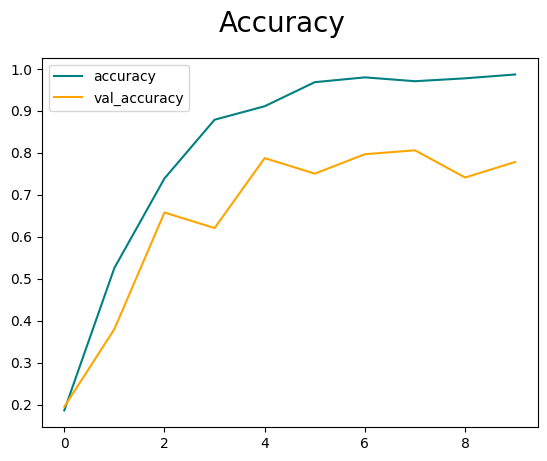

In [63]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [64]:
model.evaluate(test_ds)

4/4 [==============================] - 8s 2s/step - loss: 0.8946 - accuracy: 0.7938


[0.8946062326431274, 0.7938144207000732]

In [65]:
# Evaluate the model on the validation set
evaluation = model.evaluate(val_ds)
print("Validation Loss: {:.2f}".format(evaluation[0]))
print("Validation Accuracy: {:.2f}%".format(evaluation[1] * 100))

# Test the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss: {:.2f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

4/4 [==============================] - 5s 943ms/step - loss: 0.9593 - accuracy: 0.7870
Validation Loss: 0.96
Validation Accuracy: 78.70%
4/4 [==============================] - 6s 1s/step - loss: 0.8946 - accuracy: 0.7938
Test Loss: 0.89
Test Accuracy: 79.38%


1/1 [==============================] - 0s 50ms/step
Classes are: ['Apple', 'Beet', 'Egg Plant', 'Pepper', 'Potato', 'Squach', 'Tomato', 'carrot']
Predicted Probabilities: [0.5409772  0.41308206 0.5188429  0.5751727  0.582302   0.5561597
 0.5499544  0.39414224]


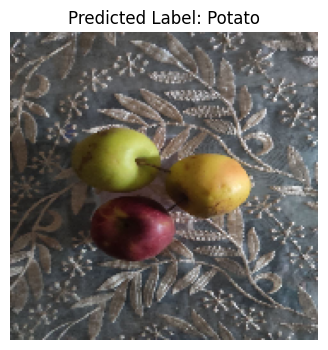

In [27]:
# Testing the 
# test_image_path = r"C:\Users\Rafik\Desktop\Master Miv\S2\RNAA\Projet\test\Egg Plant\IMG-20240412-WA0264.jpg"
# test_image_path = r"C:\Users\Rafik\Desktop\Master Miv\S2\RNAA\Projet\test\Potato\IMG_20230529_192022.jpg"
# test_image_path = r"C:\Users\Rafik\Desktop\Master Miv\S2\RNAA\Projet\test\Peeper\IMG_9578.JPG"
# test_image_path = r"C:\Users\Rafik\Desktop\Master Miv\S2\RNAA\Projet\test\Tomato\IMG_20230515_104721.jpg"
test_image_path = r"C:\Users\Rafik\Desktop\Master Miv\S2\RNAA\Projet\test\Apple\photo_5_2024-04-27_17-27-31.jpg"

def generate_predictions(test_image_path):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(180, 180))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predictions = model.predict(test_img_input)  # Get probabilities for all classes
    predicted_label = np.argmax(predictions)  # Still get the class with highest probability
    predicted_vegetable = class_names[predicted_label]
    # Print the probabilities for all classes (optional for analysis)
    print(f"Classes are: {class_names}")
    print("Predicted Probabilities:", predictions[0])  # Access probabilities for the first image (assuming batch size 1)

    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}".format(predicted_vegetable))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path)

In [67]:
model.save('model_v6.h5')

In [5]:
model = load_model('C:/Users/Rafik/Desktop/Master Miv/S2/RNAA/Projet/model_v6.h5')

In [12]:
# Load an image for prediction
image_path =r"C:\Users\Rafik\Desktop\Master Miv\S2\RNAA\Projet\test\Potato\IMG_20230529_192022.jpg"
img = image.load_img(image_path, target_size=image_shape)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image
img_array = img_array / 255.0

# Make the prediction
predictions = model.predict(img_array)
predicted_label = np.argmax(predictions[0])

# Print the predicted label
print(f"Predicted Label: {class_names[predicted_label]}")

1/1 [==============================] - 0s 319ms/step


NameError: name 'class_names' is not defined